# Cloning Dataset Repositories

In [1]:
!git clone https://gitlab.com/shimorina/webnlg-dataset.git

Cloning into 'webnlg-dataset'...
remote: Enumerating objects: 5112, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5112 (delta 2), reused 0 (delta 0), pack-reused 5106 (from 1)
Receiving objects: 100% (5112/5112), 26.09 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (4010/4010), done.
Updating files: 100% (1425/1425), done.


In [2]:
!git clone https://github.com/WebNLG/webnlg_toolkit.git
%cd webnlg_toolkit
%ls
!pip install -e .

Cloning into 'webnlg_toolkit'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 230 (delta 45), reused 211 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (230/230), 16.78 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/webnlg_toolkit
LICENSE  README.md  requirements.txt  setup.py  webnlg_toolkit/
Obtaining file:///content/webnlg_toolkit
  Preparing metadata (setup.py) ... done
  Running setup.py develop for webnlg_toolkit


# Importing Libraries

In [3]:
import os
import re
import json
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AdamW,
    get_linear_schedule_with_warmup
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import spacy

import webnlg_toolkit
from webnlg_toolkit.utils.data import load_webnlg_dataset, load_webnlg_xml

!pip install datasets
from datasets import Dataset as HFDataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00


# Preprocessing Data

In [4]:
# Path to dataset files
dataset_root = "/content/webnlg-dataset/release_v3.0/en/train/"
test_root = "/content/webnlg-dataset/release_v3.0/en/dev/"

# Function to find the dataset files
def find_dataset_files(root_folder, file_extension=".xml"):
    dataset_files = []
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(file_extension):
                dataset_files.append(os.path.join(subdir, file))
    return dataset_files

# Function to load data
def load_all_data(root_folder):
    dataset_files = find_dataset_files(root_folder, file_extension=".xml")
    all_data = []
    for file in dataset_files:
        print(f"Loading: {file}")
        data = load_webnlg_dataset(file, task="rdf2text")
        # print(data)
        all_data.extend(data)
    return all_data

# Load training and test data
train_data = load_all_data(dataset_root)
test_data = load_all_data(test_root)

# Convert to DataFrames
train_df = pd.DataFrame(train_data, columns=["input", "output"])
test_df = pd.DataFrame(test_data, columns=["input", "output"])
print(f"Training examples: {len(train_df)}")
print(f"Test examples: {len(test_df)}")

Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/CelestialBody_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/MeanOfTransportation_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Athlete_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Food_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Astronaut_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/University_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Artist_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/City_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/WrittenWork_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Company_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Politician_allSolutions.x

In [5]:
# Function to extract relations from the input using Regex
def extract_relations(input_text):
    relations = []
    pattern = r'<P>\s+(.*?)\s+<O>'
    matches = re.findall(pattern, input_text)
    return matches

# Create a new column with relation types
train_df['relations'] = train_df['input'].apply(extract_relations)
test_df['relations'] = test_df['input'].apply(extract_relations)

In [6]:
# Function to extract entities from the input using Regex
def extract_entities(input_text):
    entity_pairs = []
    pattern = r'<S>\s+(.*?)\s+<P>.*?<O>\s+(.*?)(?:\n|$)'
    matches = re.findall(pattern, input_text)
    return matches

# Create a new column with entity pairs
train_df['entity_pairs'] = train_df['input'].apply(extract_entities)
test_df['entity_pairs'] = test_df['input'].apply(extract_entities)

In [7]:
#Load a SpaCy language model
nlp = spacy.load("en_core_web_sm")

In [8]:
# Function to get the entity type
# Takes the extracted entities and uses spacy to get the type of entity
# Then, it checks the types and sorts them into its correct category
# Categories are: Person, Location, Organazion, Date, Misc (miscellaneous)
def get_entity_type(entity_text):
    doc = nlp(entity_text)
    if doc.ents:
        ent_type = doc.ents[0].label_

        if ent_type in ["PERSON", "PER"]:
            return "PERSON"
        elif ent_type in ["LOC", "GPE", "FAC"]:
            return "LOCATION"
        elif ent_type in ["ORG"]:
            return "ORGANIZATION"
        elif ent_type in ["DATE", "TIME"]:
            return "DATE"

    #Heurisitic Check
    lower_text = entity_text.lower()
    location_words = ["city", "country", "state", "river", "mountain", "ocean", "sea", "lake"]
    if any(word in lower_text for word in location_words):
        return "LOCATION"

    org_indicators = ["inc", "corp", "llc", "company", "association", "university", "institute"]
    if any(word in lower_text for word in org_indicators):
        return "ORGANIZATION"

    if re.search(r'\b(19|20)\d{2}\b', entity_text) or \
       re.search(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b', entity_text, re.IGNORECASE):
        return "DATE"

    #Default Value
    return "MISC"

In [9]:
# Make a list of all unique relations
all_relations = []
for relations in train_df['relations']:
    all_relations.extend(relations)

# Sort the unique relations and save them into unique_relations
unique_relations = sorted(list(set(all_relations)))

# Then create a mapping dictionary from relation names to numerical IDs
relation_to_id = {relation: idx for idx, relation in enumerate(unique_relations)}
# Also, create the reverse mapping from IDs back to relation names
id_to_relation = {idx: relation for relation, idx in relation_to_id.items()}

print(f"\nNumber of unique relation types: {len(unique_relations)}")


Number of unique relation types: 372


In [10]:
# Define a PyTorch Dataset class for relation extraction tasks that iscontent aware of entity types
class ContentAwareRelationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, entity_markers, entity_end_markers, max_length=128, relation_to_id=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.relation_to_id = relation_to_id
        self.entity_markers = entity_markers
        self.entity_end_markers = entity_end_markers

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Extract the relation and entity pair
        # Default to "unknown" if relations are unavailable
        relation = row['relations'][0] if len(row['relations']) > 0 else "unknown"

        # Extract the entity pair (default to empty strings if none found)
        entity_pair = row['entity_pairs'][0] if len(row['entity_pairs']) > 0 else ("", "")
        entity1, entity2 = entity_pair

        # Get context (natural language text) if available
        context = row.get('output', "")

        # Determine entity types using the entity typing function
        entity1_type = get_entity_type(entity1)
        entity2_type = get_entity_type(entity2)

        # Get type-specific markers for the entities
        # Fall back to DEFAULT markers if the specific type isn't available
        e1_start = self.entity_markers.get(entity1_type, self.entity_markers["DEFAULT"])
        e1_end = self.entity_end_markers.get(entity1_type, self.entity_end_markers["DEFAULT"])

        e2_start = self.entity_markers.get(entity2_type, self.entity_markers["DEFAULT"])
        e2_end = self.entity_end_markers.get(entity2_type, self.entity_end_markers["DEFAULT"])

        # Format text with entity markers
        if context:
            # Start with the context text
            formatted_text = context

            # Escape regex special characters in entities to avoid matching issues
            e1_esc = re.escape(entity1)
            e2_esc = re.escape(entity2)

            # Replace entities with marked versions
            # Process longer entity first to avoid substring replacement issues
            if len(entity1) >= len(entity2):
                formatted_text = re.sub(f"\\b{e1_esc}\\b", f"{e1_start} {entity1} {e1_end}", formatted_text)
                formatted_text = re.sub(f"\\b{e2_esc}\\b", f"{e2_start} {entity2} {e2_end}", formatted_text)
            else:
                formatted_text = re.sub(f"\\b{e2_esc}\\b", f"{e2_start} {entity2} {e2_end}", formatted_text)
                formatted_text = re.sub(f"\\b{e1_esc}\\b", f"{e1_start} {entity1} {e1_end}", formatted_text)

            # If entities weren't found in context, append them with markers
            if e1_start not in formatted_text:
                formatted_text += f" {e1_start} {entity1} {e1_end}"
            if e2_start not in formatted_text:
                formatted_text += f" {e2_start} {entity2} {e2_end}"
        else:
            # No context - just create a simple sequence with marked entities
            formatted_text = f"{e1_start} {entity1} {e1_end} {e2_start} {entity2} {e2_end}"

        # Tokenize the formatted text for BERT input
        encoding = self.tokenizer(
            formatted_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove batch dimension from tensors
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}

        # Add relation label if relation_to_id mapping is provided
        if self.relation_to_id:
            relation_id = self.relation_to_id.get(relation, 0)
            encoding['labels'] = torch.tensor(relation_id, dtype=torch.long)
        return encoding

In [11]:
# Define entity type markers to be used as special tokens in the input text
# These markers will wrap entities in the text to indicate their types to the model
entity_markers = {
    "PERSON": "[PERSON]",
    "LOCATION": "[LOCATION]",
    "ORGANIZATION": "[ORG]",
    "DATE": "[DATE]",
    "MISC": "[MISC]",
    "DEFAULT": "[ENTITY]"
}

# Define corresponding end markers for each entity type to close the entity spans
# These closing tags help the model identify where entities end in the text
entity_end_markers = {
    "PERSON": "[/PERSON]",
    "LOCATION": "[/LOCATION]",
    "ORGANIZATION": "[/ORG]",
    "DATE": "[/DATE]",
    "MISC": "[/MISC]",
    "DEFAULT": "[/ENTITY]"
}

# Load BERT tokenizer and include entity markers and end markers
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
special_tokens = list(entity_markers.values()) + list(entity_end_markers.values())
special_tokens_dict = {'additional_special_tokens': special_tokens}
tokenizer.add_special_tokens(special_tokens_dict)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

12

In [12]:
# Create datasets for training and testing
train_dataset = ContentAwareRelationDataset(
    train_df,
    tokenizer,
    entity_markers,
    entity_end_markers,
    max_length=128,
    relation_to_id=relation_to_id
)
test_dataset = ContentAwareRelationDataset(
    test_df,
    tokenizer,
    entity_markers,
    entity_end_markers,
    max_length=128,
    relation_to_id=relation_to_id
)

# Split training data into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator1)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 31883
Validation set size: 3543
Test set size: 4464


# Setting up the Model

In [13]:
# Creating Data Loader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
dropout_rate = 0.1

# Initialise Model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_relations),
    hidden_dropout_prob=dropout_rate,
    attention_probs_dropout_prob=dropout_rate
)
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(30534, 768, padding_idx=0)

In [14]:
# Bias Correction
beta1 = 0.9
beta2 = 0.999

# Initialise AdamW Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    betas=(beta1, beta2),
    eps=1e-8,
    weight_decay=0.01  # Weight decay for regularization
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30534, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
num_epochs = 9
total_steps = len(train_loader) * num_epochs

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training and Evaluation Functions

In [17]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        # Forward
        outputs = model(**batch)
        loss = outputs.loss

        # Backward
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    return total_loss / len(dataloader)

In [18]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            total_loss += loss.item()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return total_loss / len(dataloader), accuracy, f1, precision, recall, all_preds, all_labels

# Visualising Data Processing

In [19]:
def visualize_actual_data_with_markers(dataframe, tokenizer, entity_markers, entity_end_markers, num_examples=5):
    print("\n===== ACTUAL DATA WITH ENTITY MARKERS =====\n")

    if len(dataframe) > num_examples:
        sample_df = dataframe.sample(num_examples)
    else:
        sample_df = dataframe

    for idx, row in sample_df.iterrows():
        print(f"Example #{idx}:")
        entity_pairs = row['entity_pairs']
        relations = row['relations']
        if not entity_pairs or not relations:
            print("No entity pairs or relations found")
            continue
        entity1, entity2 = entity_pairs[0]
        relation = relations[0]
        source_text = row.get('output', row.get('input', ''))

        print(f"Original Text: {source_text}")
        print(f"Entity 1: {entity1}")
        print(f"Entity 2: {entity2}")
        print(f"Relation: {relation}")

        entity1_type = get_entity_type(entity1)
        entity2_type = get_entity_type(entity2)

        print(f"Entity 1 Type: {entity1_type}")
        print(f"Entity 2 Type: {entity2_type}")

        e1_start = entity_markers.get(entity1_type, entity_markers["DEFAULT"])
        e1_end = entity_end_markers.get(entity1_type, entity_end_markers["DEFAULT"])

        e2_start = entity_markers.get(entity2_type, entity_markers["DEFAULT"])
        e2_end = entity_end_markers.get(entity2_type, entity_end_markers["DEFAULT"])

        if source_text:
            formatted_text = source_text

            if len(entity1) >= len(entity2):
                formatted_text = formatted_text.replace(entity1, f"{e1_start} {entity1} {e1_end}")
                if entity2 in formatted_text:
                    formatted_text = formatted_text.replace(entity2, f"{e2_start} {entity2} {e2_end}")
            else:
                formatted_text = formatted_text.replace(entity2, f"{e2_start} {entity2} {e2_end}")
                if entity1 in formatted_text:
                    formatted_text = formatted_text.replace(entity1, f"{e1_start} {entity1} {e1_end}")

            if e1_start not in formatted_text:
                formatted_text += f" {e1_start} {entity1} {e1_end}"
            if e2_start not in formatted_text:
                formatted_text += f" {e2_start} {entity2} {e2_end}"
        else:
            formatted_text = f"{e1_start} {entity1} {e1_end} {e2_start} {entity2} {e2_end}"

        print(f"\nWith Entity Markers: {formatted_text}")

        tokens = tokenizer.tokenize(formatted_text)
        print(f"\nTokenized: {tokens}")

        encoded = tokenizer(
            formatted_text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        token_ids = encoded['input_ids'][0]
        decoded_text = tokenizer.decode(token_ids)
        print(f"\nDecoded for Model: {decoded_text}")
        print("\n" + "="*80 + "\n")

In [20]:
print("\nVisualizing actual data with entity markers:")
visualize_actual_data_with_markers(
    test_df.head(5),
    tokenizer,
    entity_markers,
    entity_end_markers,
    num_examples=5
)


Visualizing actual data with entity markers:

===== ACTUAL DATA WITH ENTITY MARKERS =====

Example #0:
Original Text: (29075) 1950 DA was discovered by Carl A Wirtanen.
Entity 1: (29075) 1950 DA
Entity 2: Carl A. Wirtanen
Relation: discoverer
Entity 1 Type: DATE
Entity 2 Type: PERSON

With Entity Markers: [DATE] (29075) 1950 DA [/DATE] was discovered by Carl A Wirtanen. [PERSON] Carl A. Wirtanen [/PERSON]

Tokenized: ['[DATE]', '(', '290', '##75', ')', '1950', 'da', '[/DATE]', 'was', 'discovered', 'by', 'carl', 'a', 'wi', '##rta', '##nen', '.', '[PERSON]', 'carl', 'a', '.', 'wi', '##rta', '##nen', '[/PERSON]']

Decoded for Model: [CLS] [DATE] ( 29075 ) 1950 da [/DATE] was discovered by carl a wirtanen. [PERSON] carl a. wirtanen [/PERSON] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Training Loop

In [21]:
print("\nStarting training...")
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_loss, val_accuracy, val_f1, val_precision, val_recall, _, _ = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)

    print(f"Train loss: {train_loss:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 score: {val_f1:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")


Starting training...

Epoch 1/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 3.0966
Validation loss: 1.7007
Validation accuracy: 0.7189
Validation F1 score: 0.6398
Validation Precision: 0.6081
Validation Recall: 0.7189

Epoch 2/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 1.3139
Validation loss: 0.9167
Validation accuracy: 0.8535
Validation F1 score: 0.8107
Validation Precision: 0.7877
Validation Recall: 0.8535

Epoch 3/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.7754
Validation loss: 0.6178
Validation accuracy: 0.9043
Validation F1 score: 0.8812
Validation Precision: 0.8717
Validation Recall: 0.9043

Epoch 4/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.5241
Validation loss: 0.4509
Validation accuracy: 0.9292
Validation F1 score: 0.9126
Validation Precision: 0.9054
Validation Recall: 0.9292

Epoch 5/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.3840
Validation loss: 0.3498
Validation accuracy: 0.9461
Validation F1 score: 0.9342
Validation Precision: 0.9292
Validation Recall: 0.9461

Epoch 6/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.3007
Validation loss: 0.3004
Validation accuracy: 0.9489
Validation F1 score: 0.9377
Validation Precision: 0.9315
Validation Recall: 0.9489

Epoch 7/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2497
Validation loss: 0.2724
Validation accuracy: 0.9517
Validation F1 score: 0.9420
Validation Precision: 0.9372
Validation Recall: 0.9517

Epoch 8/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2187
Validation loss: 0.2482
Validation accuracy: 0.9577
Validation F1 score: 0.9487
Validation Precision: 0.9436
Validation Recall: 0.9577

Epoch 9/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2022
Validation loss: 0.2440
Validation accuracy: 0.9588
Validation F1 score: 0.9500
Validation Precision: 0.9447
Validation Recall: 0.9588


# Saving the Model

In [22]:
model_save_path = "/content/NerBert.pt"
torch.save(model.state_dict(), model_save_path)
print(f"\nModel saved to {model_save_path}")


Model saved to /content/NerBert.pt


# Analysing Results

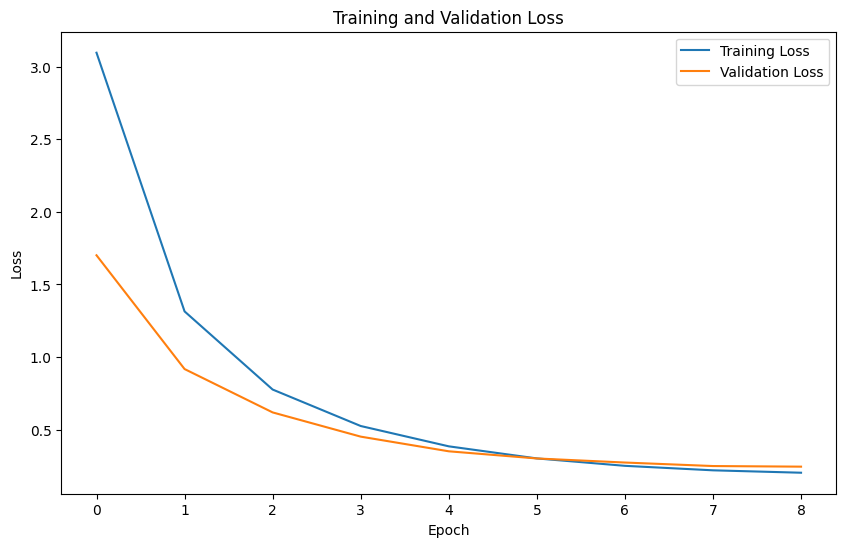

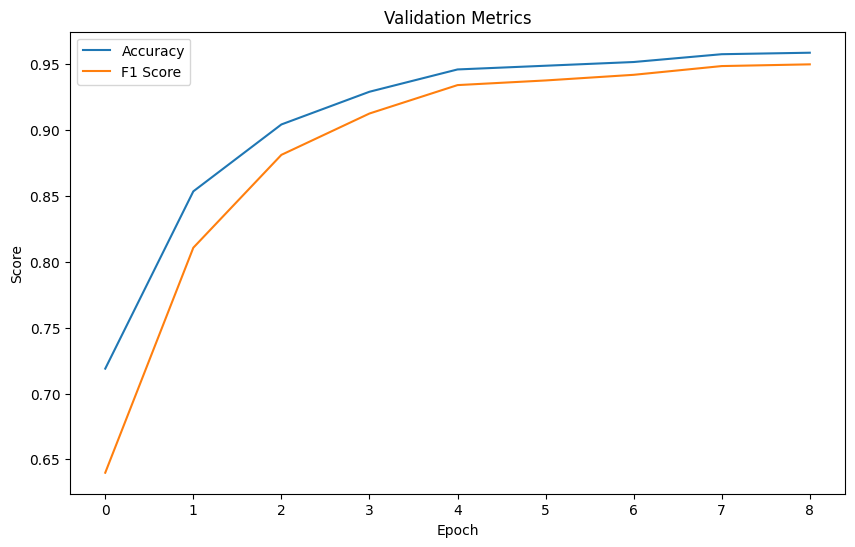

In [23]:
# Training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation accuracy and F1 score
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Accuracy')
plt.plot(val_f1_scores, label='F1 Score')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Evaluation on Dev Dataset

In [26]:
print("\nEvaluating on test set...")
test_loss, test_accuracy, test_f1, test_preds, test_labels, _, _ = evaluate(model, test_loader, device)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test F1 score: {test_f1:.4f}")


Evaluating on test set...


Evaluating:   0%|          | 0/279 [00:00<?, ?it/s]

Test loss: 0.3335
Test accuracy: 0.9411
Test F1 score: 0.9318


# Real Time Inference

In [27]:
# Extract the relation between two entities using the trained BERT model.
def extract_relation(entity1, entity2, text=None):
    encoding = tokenizer(
        entity1,
        entity2,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )
    encoding = {k: v.to(device) for k, v in encoding.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
    relation = id_to_relation.get(prediction, "unknown")

    return relation

In [28]:
print("\nExample usage:")
entity1 = "AmeriGas"
entity2 = "United States"
bert_relation = extract_relation(entity1, entity2)

print(f"Entities: '{entity1}' and '{entity2}'")
print(f"BERT predicted relation: '{bert_relation}'")


Example usage:
Entities: 'AmeriGas' and 'United States'
BERT predicted relation: 'region served'
